# Base Case: Circular Orbit of Radius 1 AU, Period 1 Year

Create synthetic data for the simplest base case: a circular orbit of radius 1.

Can think of this as approximating the earth: radius = 1 AU, period = 1 year, mass of sun $m_0$ = 1 solar mass

\begin{align}
x(t) &= \cos(\omega t) \\
y(t) &= \sin(\omega t) \\
\omega &= 2 \pi
\end{align}

Taking two derivatives
\begin{align}
\ddot{x}(t) = -\omega^2 x(t)\\
\ddot{y}(t) = -\omega^2 y(t)
\end{align}

Equating the acceleration to $G \cdot m_0$, we can see that in these units the gravitational constant $G$ is
$$G = 4 \pi^2$$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Aliases
keras = tf.keras

# Local imports
import utils

In [58]:
# Grow GPU memory
utils.gpu_grow_memory()

# Plot style 
utils.plot_style()

In [59]:
def make_train_r2bc(r, theta0):
    """
    Make an array of training data points for the restricted 2 body circular problem.
    INPUTS:
    r: The radius of the orbit in AU
    theta0: the angle of the planet in the ecliptic at time 0 years
    RETURNS:
    input_dict: a dictionary with the input fields t, q0, v0
    output_dict: a dictionary with the output fields q, v, a
    """
    # Number of samples; 10 years, 365 times per year
    N = 365*10 + 1
    # Sample time at intervals of 365 per year (approximately daily) over 10 years
    t = np.arange(N, dtype=np.float32) / 365.0

    # The angular velocity of the earth in the (AU, years) coordinate units
    omega_earth = 2.0 * np.pi
    # The gravitational constant in units of (AU, years, solar_mass)
    G = omega_earth**2
    # The mass of the sun in this coordinate system
    m0 = 1.0
    # The gravitational coefficient G*(m0 + m1) for the restricted two body problem in these units
    mu = G * (m0)

    # Set the angular frequency omega based on the radius using the relationship
    # mu = omega^2 r^3 --> omega = sqrt(mu / r^3)
    omega = np.sqrt(mu / r**3)
    # Theta is offset by theta0
    theta = (omega * t) - theta0

    # Compute qx and qy from r and theta; wrap into position q
    qx = r*np.cos(theta, dtype=np.float32)
    qy = r*np.sin(theta, dtype=np.float32)
    q = np.stack([qx, qy], axis=1)
    
    # Compute vx and vy; wrap into velocity v
    vx = -omega * qx
    vy = +omega * qy
    v = np.stack([vx, vy], axis=1)
    
    # Compute ax and ay; wrap into acceleration a
    ax = -omega**2 * qx
    ay = -omega**2 * qy
    a = np.stack([ax, ay], axis=1)

    # Repeat vectors for the initial position q0
    qx0 = np.ones(N) * qx[0]
    qy0 = np.ones(N) * qy[0]
    q0 = np.stack([qx0, qy0], axis=1)
    
    # Repeat vectors for the initial velocity v0
    vx0 = np.ones(N) * vx[0]
    vy0 = np.ones(N) * vy[0]
    v0 = np.stack([vx0, vy0], axis=1)
    
    # Assemble the input dict
    inputs = {
        't': t,
        'q0': q0,
        'v0': v0}

    # Assemble the output dict
    outputs = {
        'q': q,
        'v': v,
        'a': a}
    
    # Return the dicts
    return (inputs, outputs)

In [60]:
# Generate inputs and outputs for the earth's orbit
inputs, outputs = make_train_r2bc(1.0, 0.0)

# Combined dict
data = {**inputs, **outputs}

# Unpack inputs
t = inputs['t']
q0 = inputs['q0']
v0 = inputs['v0']

# Unpack outputs
q = outputs['q']
v = outputs['v']
a = outputs['a']

In [69]:
def plot_orbit_q(data):
    """Plot the orbit position combined data in a training sample"""
    # Unpack data
    num_days = 365
    t = data['t'][0:num_days]
    q = data['q'][0:num_days]
    qx = q[:, 0]
    qy = q[:, 1]
    
    # Plot the x and y coordinate
    fig, ax = plt.subplots(figsize=[16, 9])
    ax.set_title('Orbit Position')
    ax.set_xlabel('t - years')
    ax.set_ylabel('q - AU')
    ax.set_xticks([0, 0.25, 0.50, 1.0])
    ax.plot(t, qx, color='b', label='x')
    ax.plot(t, qy, color='r', label='y')
    ax.grid()
    ax.legend()
    
    return fig, ax

In [96]:
def plot_orbit_r(data):
    """Plot the orbit position combined data in a training sample"""
    # Unpack data
    num_days = 365
    t = data['t'][0:num_days]
    q = data['q'][0:num_days]
    r = np.linalg.norm(q, axis=1)
    
    # Plot the x and y coordinate
    fig, ax = plt.subplots(figsize=[16, 9])
    ax.set_title('Orbit Distance')
    ax.set_xlabel('t - years')
    ax.set_ylabel('r - AU')
    ax.set_xticks([0, 0.25, 0.50, 1.0])
    # ax.ticklabel_format(useOffset=False)
    ax.set_ylim(0.0, np.max(r)*1.05)
    ax.plot(t, r, color='b', label='x')
    ax.grid()
    ax.legend()
    
    return fig, ax

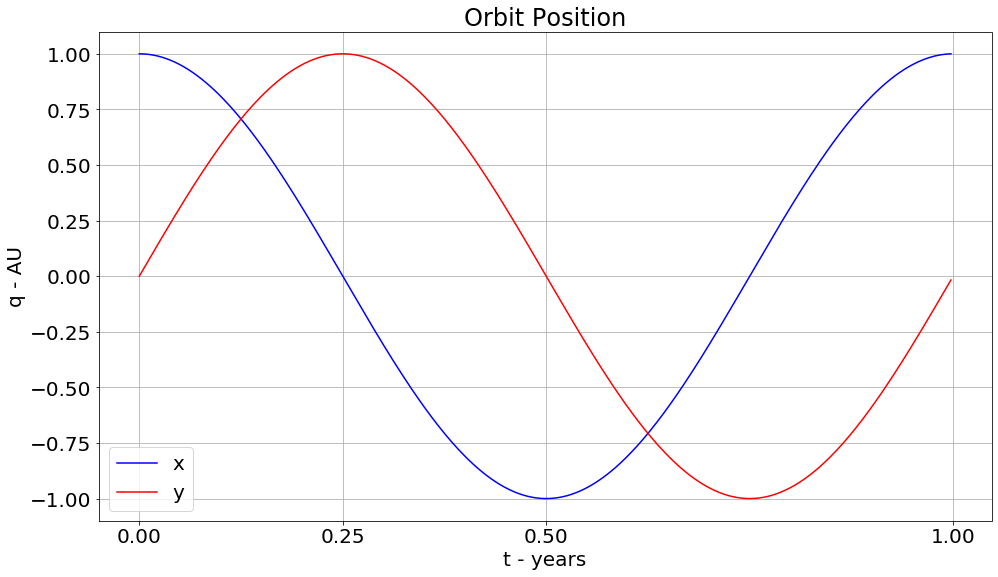

In [97]:
fig, ax = plot_orbit_q(data)

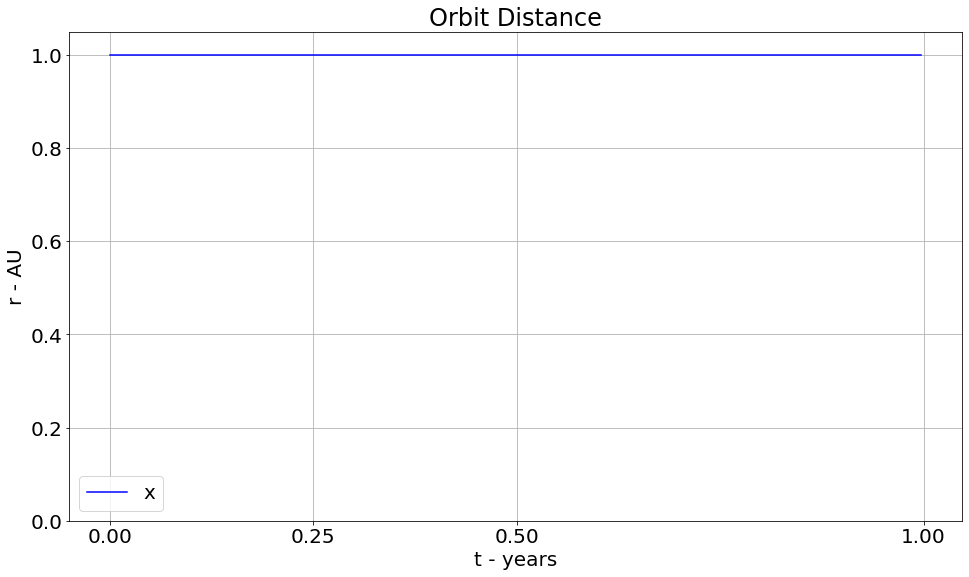

In [98]:
fig, ax = plot_orbit_r(data)

In [85]:
# Create a DataSet
ds = tf.data.Dataset.from_tensor_slices((inputs, outputs))
ds

<TensorSliceDataset shapes: ({t: (), q0: (2,), v0: (2,)}, {q: (2,), v: (2,), a: (2,)}), types: ({t: tf.float32, q0: tf.float64, v0: tf.float64}, {q: tf.float32, v: tf.float32, a: tf.float32})>

In [178]:
def make_model_r2bc():
    """Create a model for the restricted two body circular problem"""
    # Create input layers
    input_t = keras.Input(shape=(1,), name='t')
    input_q0 = keras.Input(shape=(2,), name='q0')
    input_v0 = keras.Input(shape=(2,), name='v0')
    inputs = [input_t, input_q0, input_v0]
    
    # Combine the input features
    x1 = keras.layers.concatenate(inputs=[input_t, input_q0, input_v0], name='concat_inputs') 
    
    # 2 Dense feature layers
    x2 = keras.layers.Dense(units=16, activation='tanh', name='x2')(x1)
    x3 = keras.layers.Dense(units=16, activation='tanh', name='x3')(x2)
    
    # The radius r
    r = keras.layers.Dense(1, name='r')(x3)
    
    # The angular velocity omega
    omega = keras.layers.Dense(1, name='omega')(x3)
    neg_omega = tf.math.negative(omega)
    
    # The angle theta and its negative
    theta = keras.layers.multiply(inputs=[omega, input_t], name='theta')
    
    # Cosine and sine of theta
    cos_theta = keras.backend.cos(theta, name='cos_theta')
    sin_theta = keras.backend.sin(theta)
    
    # Compute qx and qy from r, theta
    # qx = r * tf.cos(theta)
    # qy = r * tf.sin(theta)
    qx = keras.layers.multiply(inputs=[r, cos_theta], name='qx')
    qy = keras.layers.multiply(inputs=[r, sin_theta], name='qy')
    q = keras.layers.concatenate(inputs=[qx, qy], name='concat_q')
    
    # Compute vx and vy from r, theta
    # TODO: generalize derivative computation using GradientTape
    # vx = -omega * qy
    # vy = omega * qx
    vx = keras.layers.multiply(inputs=[neg_omega, qy], name='vx')
    vy = keras.layers.multiply(inputs=[omega, qx], name='vy')
    v = keras.layers.concatenate(inputs=[vx, vy], name='concat_v')
    
    # Compute ax and ay from r, theta
    # TODO: generalize derivative computation using GradientTape
    # omega2 = tf.square(omega)
    omega2 = omega * omega
    ax = -omega2 * qx
    ay = -omega2 * qy
    a = keras.layers.concatenate(inputs=[ax, ay], name='concat_a')
    
    # The output layers
    outputs = [q, v, a]
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='r2bc')
    return model

In [177]:
model = make_model_r2bc()

TypeError: cos() got an unexpected keyword argument 'name'

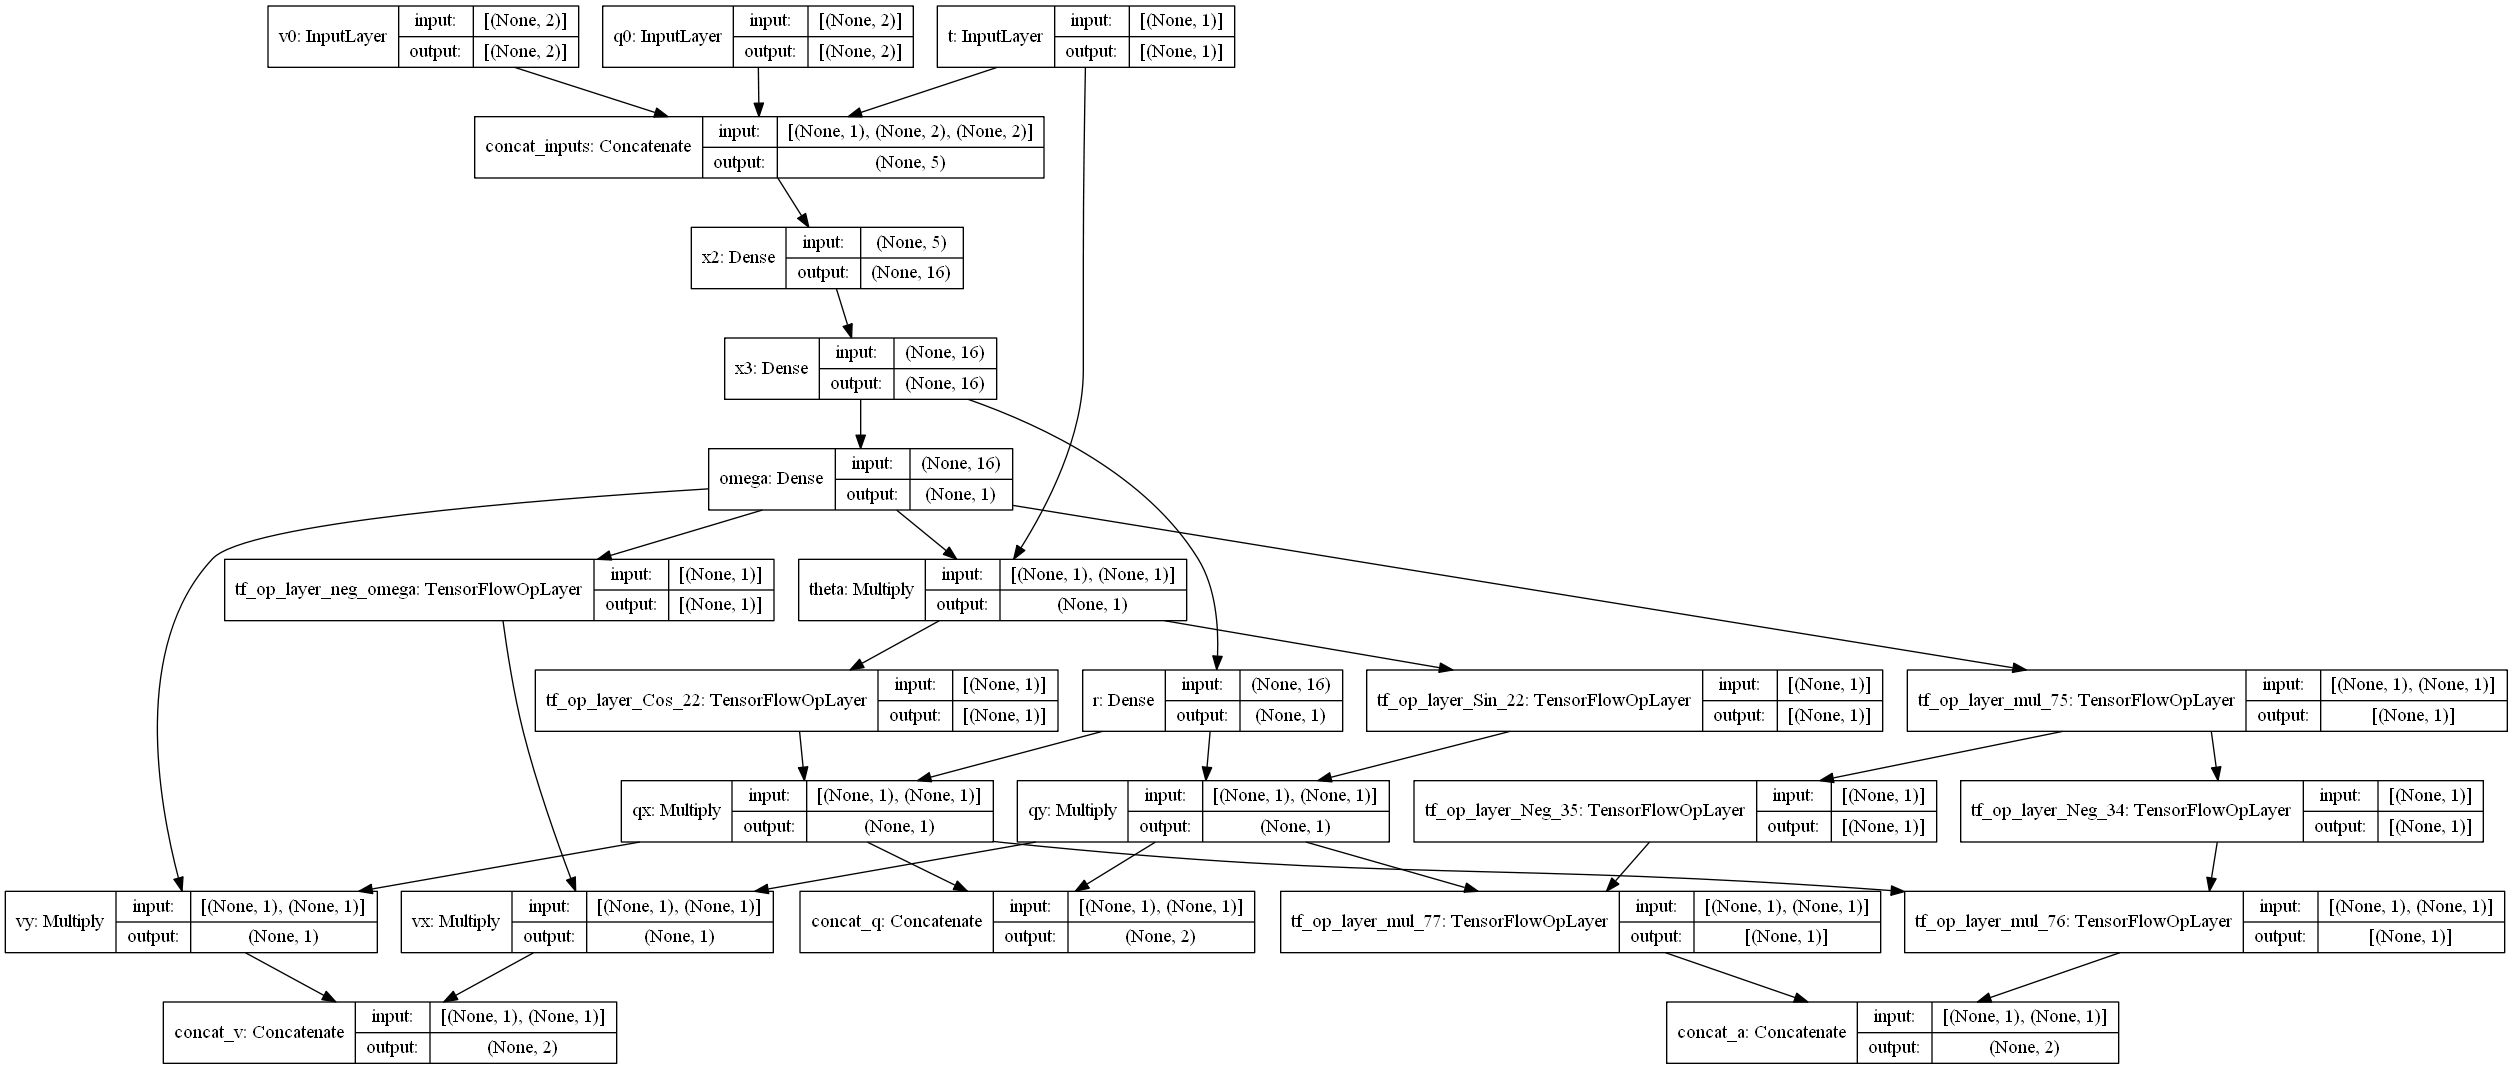

In [174]:
keras.utils.plot_model(model, show_shapes=True)

In [175]:
model.summary()

Model: "r2bc"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
t (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
q0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
v0 (InputLayer)                 [(None, 2)]          0                                            
__________________________________________________________________________________________________
concat_inputs (Concatenate)     (None, 5)            0           t[0][0]                          
                                                                 q0[0][0]                      

In [134]:
model.compile

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
# The semi-major axis
orb_a = tf.keras.layers.Dense(1)(inputs_stack)

# The eccentricity
orb_e = tf.Variable(0.0, name='e')

# The angular frequency omega
omega = tf.Variable(omega_earth, name='omega')

# The angle theta (true anomaly)
theta = omega * input_t

# The semi-latus rectum
orb_p = orb_a * (1.0 - orb_e*orb_e)

# The radius
r = orb_p / (1 + orb_e * tf.cos(theta))

# The x and y position
x = r * tf.cos(theta)
y = r * tf.sin(theta)
q = tf.concat([x, y], axis=1)

# The x and y velocity
#TODO: update this later with automatic differentiation!
vx = omega * r * tf.cos(theta)
vy = omega * r * tf.sin(theta)
v = tf.concat([vx, vy], axis=1)

In [ ]:
a

In [ ]:
p

In [ ]:
omega

In [ ]:
theta

In [ ]:
q

In [ ]:
# Outputs
outputs = [q, v]
outputs

In [ ]:
# Wrap model
# model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model = tf.keras.models.Model(inputs=inputs, outputs=a)

In [ ]:
model(inputs)

In [ ]:
model.trainable_variables

In [ ]:
model(inputs_batch)